In [2]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
from neuromaps import datasets, transforms, images, resampling, nulls, stats
import matplotlib.pyplot as plt

In [3]:
!wb_command -version

Connectome Workbench
Type: Command Line Application
Version: 2.0.1
Qt Compiled Version: 6.2.3
Qt Runtime Version: 6.2.3
Commit: 150de12f4f4b94b39bec6d9133ad2e7019d2d3ef
Commit Date: 2024-10-15 17:38:41 -0500
Compiler: c++ (/Applications/Xcode.app/Contents/Developer/Toolchains/XcodeDefault.xctoolchain/usr/bin)
Compiler Version: 13.0.0.13000029
Compiled Debug: NO
Operating System: Apple OSX
Compiled with OpenMP: YES


In [4]:
brain_maps = [
    {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'},
    {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'},
    {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'},
    {'source': 'reardon2018', 'desc': 'scalingnih', 'space': 'civet', 'den': '41k'},
    {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'},
    {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'},
    {'source': 'raichle', 'desc': 'cmrglc', 'space': 'fsLR', 'den': '164k'},
    {'source': 'mueller2013', 'desc': 'intersubjvar', 'space': 'fsLR', 'den': '164k'}
]
single_sphere_counter = 0
for map in brain_maps:
    brain_map = datasets.fetch_annotation(**map)
    if len(brain_map) != 2:
        single_sphere_counter += 1
        print(map)
print(single_sphere_counter)


[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'myelinmap', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker, John Harwell, Essa Yacoub, Kamil Ugurbil, Jespe

In [5]:
def is_volumetric(map_dict):
    return map_dict.get('space') in ['MNI152', 'MNI305']


def load_and_prepare_map(map_dict, target_space='fsLR', target_den='164k'):
    print(f"  Loading {map_dict['desc']}...")
    
    # Fetch the map
    brain_map = datasets.fetch_annotation(**map_dict)
    
    # Check if volumetric
    if is_volumetric(map_dict):
        print(f"Volumetric map detected, transforming to {target_space} surface...")
        
        # Transform volumetric to surface (both hemispheres)
        try:
            surface_map = transforms.mni152_to_fslr(brain_map, fslr_density=target_den)
            # surface_map will be a tuple of (left_hemi, right_hemi)
            lh_data = images.load_data(surface_map[0])
            rh_data = images.load_data(surface_map[1])
            full_data = np.hstack([lh_data, rh_data])
            return full_data, target_space, target_den
            
        except Exception as e:
            print(f"    Warning: Could not transform volumetric map: {e}")
 
    # Surface map processing
    else:
        src_space = map_dict.get('space')
        src_den = map_dict.get('den')
        template = {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}
        template_map = datasets.fetch_annotation(**template)
        # Load both hemispheres
        if len(brain_map) == 2:
            lh_map, rh_map = brain_map
        else:
            raise ValueError(f"Expected 2 hemispheres for surface map, got {len(brain_map)}")
        
        # Resample if needed
        if src_den != target_den or src_space != target_space:
            print(f"Resampling from {src_space}-{src_den} to {target_space}-{target_den}...")            
            # Resample both hemispheres
            lh_resampled, _ = resampling.resample_images(
                lh_map, template_map[0],
                src_space=src_space, trg_space=target_space,
                hemi='L', resampling='transform_to_trg'
            )
            rh_resampled, _ = resampling.resample_images(
                rh_map, template_map[1],
                src_space=src_space, trg_space=target_space,
                hemi='R', resampling='transform_to_trg'
            )
            
            lh_data = images.load_data(lh_resampled)
            rh_data = images.load_data(rh_resampled)
        else:
            lh_data = images.load_data(lh_map)
            rh_data = images.load_data(rh_map)
        
        # Concatenate both hemispheres
        full_data = np.hstack([lh_data, rh_data])
        return full_data, src_space if src_den == target_den else target_space, \
               src_den if src_den == target_den else target_den


In [6]:
map = load_and_prepare_map(brain_maps[4])

  Loading way100635...

[References] Please cite the following papers if you are using this data:

  For {'source': 'savli2012', 'desc': 'way100635', 'space': 'MNI152', 'res': '3mm'}:
  [primary]:
    Markus Savli, Andreas Bauer, Markus Mitterhauser, Yu-Shin Ding, Andreas Hahn, Tina Kroll, Alexander Neumeister, Daniela Haeusler, Johanna Ungersboeck, Shannan Henry, and others. Normative database of the serotonergic system in healthy subjects using multi-tracer pet. Neuroimage, 63(1):447–459, 2012.
  [secondary]:
    
Volumetric map detected, transforming to fsLR surface...


In [7]:
def compute_spin_covariance_matrix(brain_maps, n_perm=1000, target_space='fsLR', 
                                   target_den='32k', seed=1234, metric='pearsonr'):
    """
    Compute covariance matrix with Alexander-Bloch spin test correction
    Uses BOTH hemispheres for all maps
    
    Returns:
        cov_empirical: Empirical covariance matrix
        cov_pvalues: P-values for each covariance
        cov_corrected: Covariance matrix with non-significant values set to 0
        correlation_matrix: Correlation matrix (standardized covariance)
    """
    n_maps = len(brain_maps)
    prepared_maps = []
    map_names = []
    map_spaces = []
    map_dens = []
    for i, brain_map in enumerate(brain_maps):
        print(f"\nMap {i+1}/{n_maps}: {brain_map['source']} - {brain_map['desc']}")
        try:
            prep_map, final_space, final_den = load_and_prepare_map(
                brain_map, target_space, target_den
            )
            prepared_maps.append(prep_map)
            map_names.append(f"{brain_map['source']}_{brain_map['desc']}")
            map_spaces.append(final_space)
            map_dens.append(final_den)
            print(f"Successfully prepared: {len(prep_map)} vertices")
        except Exception as e:
            print(f"Failed to prepare map: {e}")
            raise
    print("Generating spatial null distributions")
    nulls_list = []
    for i, prep_map in enumerate(prepared_maps):
        print(f"\nMap {i+1}/{n_maps}: {map_names[i]}")
        print(f"  Generating {n_perm} spin rotations...")
        try:
            rotated = nulls.alexander_bloch(
                prep_map,
                atlas=target_space,
                density=target_den,
                n_perm=n_perm,
                seed=seed  # Different seed for each map
            )
            nulls_list.append(rotated)
            print(f"Generated null distribution: shape {rotated.shape}")
        except Exception as e:
            print(f"Failed to generate nulls: {e}")
            raise

    cov_empirical = np.zeros((n_maps, n_maps))
    cov_pvalues = np.ones((n_maps, n_maps))
    corr_empirical = np.zeros((n_maps, n_maps))
    
    # Diagonal elements (variances)
    for i in range(n_maps):
        mask = ~np.isnan(prepared_maps[i])
        cov_empirical[i, i] = np.var(prepared_maps[i][mask])
        cov_pvalues[i, i] = 0.0
        corr_empirical[i, i] = 1.0
    
    # Off-diagonal elements (covariances)
    pair_count = 0
    total_pairs = n_maps * (n_maps - 1) // 2
    
    for i in range(n_maps):
        for j in range(i+1, n_maps):
            pair_count += 1
            print(f"\nPair {pair_count}/{total_pairs}: {map_names[i]} vs {map_names[j]}")
            
            # Check if maps have compatible dimensions
            if len(prepared_maps[i]) != len(prepared_maps[j]):
                print(f"Maps have different lengths: {len(prepared_maps[i])} vs {len(prepared_maps[j])}")
                print(f"Skipping this pair...")
                continue
            
            # Use compare_images to get correlation with spin test
            # This compares rotated versions of map i to ORIGINAL map j
            try:
                corr_emp, p_spin = stats.compare_images(
                    prepared_maps[i],  # source (will be rotated)
                    prepared_maps[j],  # target (stays original)
                    metric=metric,
                    nulls=nulls_list[i],  # rotated versions of source
                    nan_policy='omit'
                )
                
                print(f"Correlation: {corr_emp:.4f}")
                print(f"P-value (spin): {p_spin:.4f} {'***' if p_spin < 0.001 else '**' if p_spin < 0.01 else '*' if p_spin < 0.05 else ''}")
                
                # Store correlation
                corr_empirical[i, j] = corr_emp
                corr_empirical[j, i] = corr_emp
                cov_pvalues[i, j] = p_spin
                cov_pvalues[j, i] = p_spin
                
                # Compute covariance from correlation
                # Cov(X,Y) = Corr(X,Y) * SD(X) * SD(Y)
                mask = ~np.isnan(prepared_maps[i]) & ~np.isnan(prepared_maps[j])
                std_i = np.std(prepared_maps[i][mask])
                std_j = np.std(prepared_maps[j][mask])
                cov_emp = corr_emp * std_i * std_j
                
                cov_empirical[i, j] = cov_emp
                cov_empirical[j, i] = cov_emp
                
                print(f"Covariance: {cov_emp:.6f}")
                print(f"Valid vertices: {np.sum(mask)}/{len(mask)}")
                
            except Exception as e:
                print(f"Failed to compare maps: {e}")
                continue
    
    return cov_empirical, cov_pvalues, corr_empirical, map_names

In [8]:
import time
start_time = time.perf_counter()

cov_emp, cov_pvals, corr_emp, names = compute_spin_covariance_matrix(
    brain_maps, 
    n_perm=1000,
    target_space='fsLR',
    target_den='32k',  # Using 32k as it's a good middle ground
    seed=1234
)

end_time = time.perf_counter()
corr_df = pd.DataFrame(corr_emp, index=names, columns=names)
print(corr_df)



Map 1/8: abagen - genepc1
  Loading genepc1...

[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker,

In [9]:
corr_df

,abagen_genepc1,hcps1200_myelinmap,hcps1200_thickness,reardon2018_scalingnih,savli2012_way100635,margulies2016_fcgradient01,raichle_cmrglc,mueller2013_intersubjvar
abagen_genepc1,1.000000,0.786310,-0.697060,-0.141600,-0.705457,-0.520205,0.442187,-0.435782
hcps1200_myelinmap,0.786310,1.000000,-0.557634,-0.196669,-0.636402,-0.523661,0.312348,-0.470808
hcps1200_thickness,-0.697060,-0.557634,1.000000,0.135482,0.627978,0.356469,-0.397825,0.273599
reardon2018_scalingnih,-0.141600,-0.196669,0.135482,1.000000,0.128794,0.216761,0.112481,0.358143
savli2012_way100635,-0.705457,-0.636402,0.627978,0.128794,1.000000,0.379455,-0.531378,0.340173
margulies2016_fcgradient01,-0.520205,-0.523661,0.356469,0.216761,0.379455,1.000000,0.072156,0.487523
raichle_cmrglc,0.442187,0.312348,-0.397825,0.112481,-0.531378,0.072156,1.000000,0.122105
mueller2013_intersubjvar,-0.435782,-0.470808,0.273599,0.358143,0.340173,0.487523,0.122105,1.000000


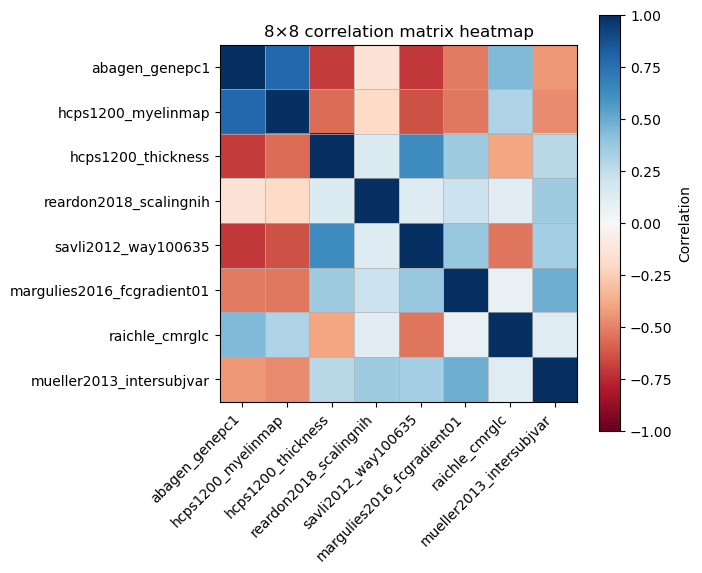

In [10]:
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_df, vmin=-1, vmax=1, cmap='RdBu')  # correlation range

# ticks + labels
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=45, ha="right")
ax.set_yticklabels(names)

# grid lines to separate cells
ax.set_xticks(np.arange(-.5, len(names), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(names), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Correlation")

ax.set_title("8×8 correlation matrix heatmap")
plt.tight_layout()
plt.show()

In [11]:
cov_pvals_df = pd.DataFrame(cov_pvals, index=names, columns=names)
cov_pvals_df

,abagen_genepc1,hcps1200_myelinmap,hcps1200_thickness,reardon2018_scalingnih,savli2012_way100635,margulies2016_fcgradient01,raichle_cmrglc,mueller2013_intersubjvar
abagen_genepc1,0.000000,0.000999,0.000999,0.370629,0.000999,0.002997,0.042957,0.038961
hcps1200_myelinmap,0.000999,0.000000,0.000999,0.137862,0.000999,0.000999,0.109890,0.000999
hcps1200_thickness,0.000999,0.000999,0.000000,0.352647,0.000999,0.009990,0.033966,0.096903
reardon2018_scalingnih,0.370629,0.137862,0.352647,0.000000,0.562438,0.255744,0.590410,0.019980
savli2012_way100635,0.000999,0.000999,0.000999,0.562438,0.000000,0.028971,0.000999,0.033966
margulies2016_fcgradient01,0.002997,0.000999,0.009990,0.255744,0.028971,0.000000,0.687313,0.005994
raichle_cmrglc,0.042957,0.109890,0.033966,0.590410,0.000999,0.687313,0.000000,0.576424
mueller2013_intersubjvar,0.038961,0.000999,0.096903,0.019980,0.033966,0.005994,0.576424,0.000000


## Principal Component Analysis (PCA)

**Goal:** Reduce the 8×8 Spearman correlation matrix into a small set of orthogonal latent axes (principal components) that capture maximal shared variance across brain maps.

### Inputs
- `corr_df_spear`: pandas DataFrame containing the Spearman correlation matrix $R \in \mathbb{R}^{8\times 8}$ across the 8 brain maps.
- `names`: list of brain map names aligned to the rows/columns of `corr_df_spear`.

### Steps implemented in code

1. **Eigendecomposition of the correlation matrix**
   - Because \(R\) is symmetric, the code uses `np.linalg.eigh`, which is numerically stable and tailored to symmetric matrices.
   - `eigh` returns eigenvalues in **ascending** order.

   **Code behavior:**
   - `eigvals, eigvecs = np.linalg.eigh(corr_df_spear.values)`

2. **Sort eigenvalues/eigenvectors in descending order**
   - PCA convention labels PC1 as the component with the largest eigenvalue.
   - The code sorts eigenvalues in descending order and reorders eigenvectors accordingly.

   **Code behavior:**
   - `idx = np.argsort(eigvals)[::-1]`
   - `eigvals = eigvals[idx]`
   - `eigvecs = eigvecs[:, idx]`

3. **Compute variance explained**
   - The proportion of variance explained by each PC is computed as:
     $$
     \text{var\_exp}_k = \frac{\lambda_k}{\sum_{j=1}^{p}\lambda_j}
     $$
   - Where $\lambda_k$ is the $k$-th eigenvalue.

   **Code behavior:**
   - `var_exp = eigvals / eigvals.sum()`

4. **Compute component loadings**
   - To obtain interpretable contributions of each map to each component, loadings are computed as:
     $$
     L = V\Lambda^{1/2}
     $$
     where \(V\) contains eigenvectors and $\Lambda$ is the diagonal matrix of eigenvalues.
   - This rescales eigenvectors by the square root of the component variance.

   **Code behavior:**
   - `loadings = eigvecs * np.sqrt(eigvals)`
   - Broadcasting multiplies each column $k$ of `eigvecs` by $\sqrt{\lambda_k}$.

5. **PC1 vs PC2 loading scatter plot**
   - The code extracts the first two loading columns for a 2D scatter:
     - `x = loadings[:, 0]` (PC1 loadings)
     - `y = loadings[:, 1]` (PC2 loadings)
   - Points are labeled with the corresponding brain map name from `names`.
   - Axes include the variance explained for PC1/PC2 via `var_exp`.

   **Code behavior:**
   - Draw axes at 0 (horizontal and vertical reference lines)
   - Scatter plot `x` vs `y`
   - Label each point with the map name
   - Axis labels: `PC1 loading (var=...)`, `PC2 loading (var=...)`

### Outputs
- `eigvals`: eigenvalues (sorted descending)
- `eigvecs`: eigenvectors aligned to sorted eigenvalues
- `var_exp`: variance explained per PC
- `loadings`: map-by-PC matrix of PCA loadings
- Figure: PC1 vs PC2 loading scatter (with labels)

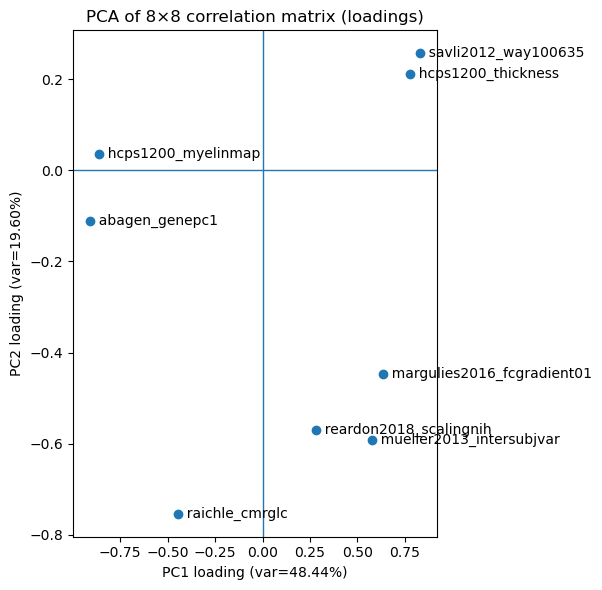

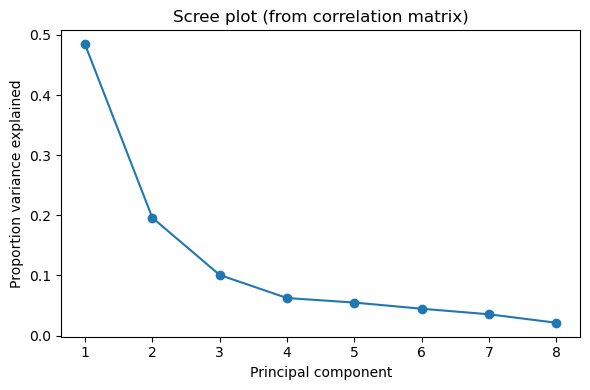

In [12]:
eigvals, eigvecs = np.linalg.eigh(corr_df.values)  # ascending
idx = np.argsort(eigvals)[::-1]       # sort descending
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
# variance explained
var_exp = eigvals / eigvals.sum()
# Calculate Loadings
loadings = eigvecs * np.sqrt(eigvals)
# Coordinates for PC1/PC2 plot
x = loadings[:, 0]
y = loadings[:, 1]
# Plot: loadings scatter with labels
plt.figure(figsize=(6, 6))
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.scatter(x, y)
for i, name in enumerate(names):
    plt.text(x[i], y[i], "  " + name, va="center")
plt.xlabel(f"PC1 loading (var={var_exp[0]:.2%})")
plt.ylabel(f"PC2 loading (var={var_exp[1]:.2%})")
plt.title("PCA of 8×8 correlation matrix (loadings)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 9), var_exp, marker="o")
plt.xticks(np.arange(1, 9))
plt.xlabel("Principal component")
plt.ylabel("Proportion variance explained")
plt.title("Scree plot (from correlation matrix)")
plt.tight_layout()
plt.show()

In [13]:
for i, eigval in enumerate(eigvals):
    print(f"PC{i+1}: Eigenvalue = {eigval:.3f}")
    for j, name in enumerate(names):
        print(f"Map Name : {name}, PC {i+1} loading = {loadings[i][j]}")

PC1: Eigenvalue = 3.875
Map Name : abagen_genepc1, PC 1 loading = -0.9116810437484624
Map Name : hcps1200_myelinmap, PC 1 loading = -0.11163084186922893
Map Name : hcps1200_thickness, PC 1 loading = 0.08253112231319389
Map Name : reardon2018_scalingnih, PC 1 loading = 0.010350943206518604
Map Name : savli2012_way100635, PC 1 loading = -0.002528366363721932
Map Name : margulies2016_fcgradient01, PC 1 loading = -0.17110048794155355
Map Name : raichle_cmrglc, PC 1 loading = -0.08914087902904769
Map Name : mueller2013_intersubjvar, PC 1 loading = -0.3350072171063838
PC2: Eigenvalue = 1.568
Map Name : abagen_genepc1, PC 2 loading = -0.8610058266998938
Map Name : hcps1200_myelinmap, PC 2 loading = 0.03522532269194303
Map Name : hcps1200_thickness, PC 2 loading = 0.09832918846930418
Map Name : reardon2018_scalingnih, PC 2 loading = -0.07884890158410732
Map Name : savli2012_way100635, PC 2 loading = 0.15032594765898594
Map Name : margulies2016_fcgradient01, PC 2 loading = -0.41568914650432365


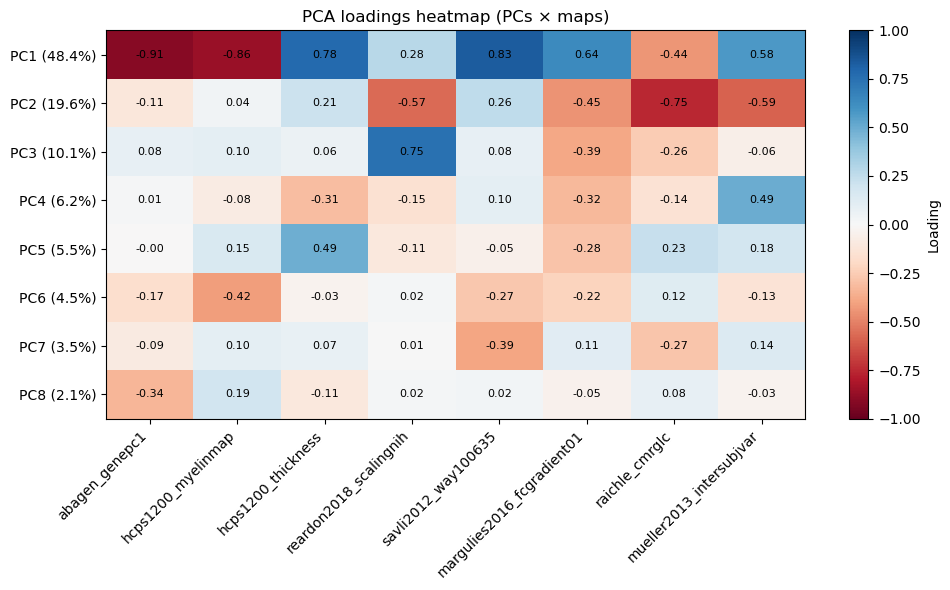

In [14]:
L = loadings.T  # (8 PCs, 8 maps)
plt.figure(figsize=(10, 6))
im = plt.imshow(L, aspect="auto", vmin=-1, vmax=1, cmap='RdBu')
# axis labels
plt.xticks(np.arange(len(names)), names, rotation=45, ha="right")
plt.yticks(np.arange(len(L)), [f"PC{i+1} ({var_exp[i]:.1%})" for i in range(len(L))])
plt.title("PCA loadings heatmap (PCs × maps)")
# annotate each cell value
for i in range(len(L)):
    for j in range(len(names)):
        plt.text(j, i, f"{L[i, j]:.2f}", ha="center", va="center", fontsize=8)
plt.colorbar(im, label="Loading")
plt.tight_layout()
plt.show()

In [15]:
cov_emp, cov_pvals, corr_emp, names = compute_spin_covariance_matrix(
    brain_maps, 
    n_perm=1000,
    target_space='fsLR',
    target_den='32k',  # Using 32k as it's a good middle ground
    seed=1234,
    metric='spearmanr'
)
end_time = time.perf_counter()
corr_df_spear = pd.DataFrame(corr_emp, index=names, columns=names)
print(corr_df_spear)



Map 1/8: abagen - genepc1
  Loading genepc1...

[References] Please cite the following papers if you are using this data:

  For {'source': 'abagen', 'desc': 'genepc1', 'space': 'fsaverage', 'den': '10k'}:
  [primary]:
    Michael J Hawrylycz, Ed S Lein, Angela L Guillozet-Bongaarts, Elaine H Shen, Lydia Ng, Jeremy A Miller, Louie N Van De Lagemaat, Kimberly A Smith, Amanda Ebbert, Zackery L Riley, and others. An anatomically comprehensive atlas of the adult human brain transcriptome. Nature, 489(7416):391, 2012.
    Ross D Markello, Aurina Arnatkeviciute, Jean-Baptiste Poline, Ben D Fulcher, Alex Fornito, and Bratislav Misic. Standardizing workflows in imaging transcriptomics with the abagen toolbox. eLife, 10:e72129, 2021.
  [secondary]:
    

[References] Please cite the following papers if you are using this data:

  For {'source': 'hcps1200', 'desc': 'thickness', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Matthew F Glasser, Timothy S Coalson, Emma C Robinson, Carl D Hacker,

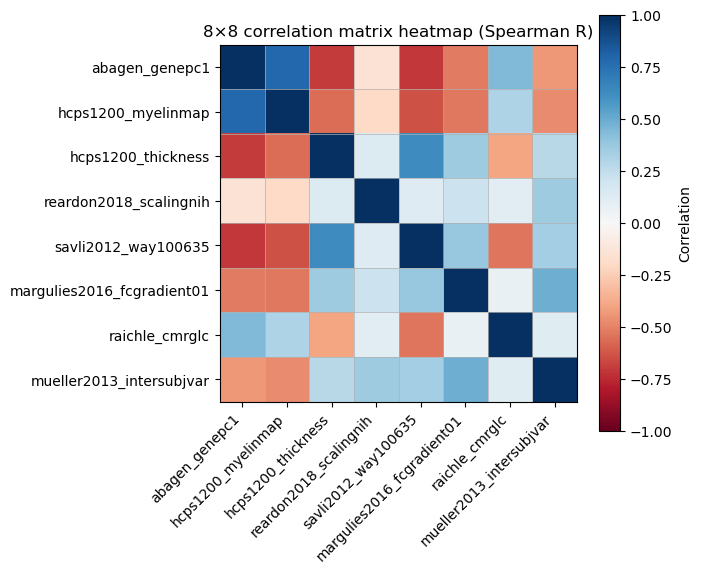

In [16]:
fig, ax = plt.subplots(figsize=(7, 6))
im = ax.imshow(corr_df, vmin=-1, vmax=1, cmap='RdBu')  # correlation range

# ticks + labels
ax.set_xticks(np.arange(len(names)))
ax.set_yticks(np.arange(len(names)))
ax.set_xticklabels(names, rotation=45, ha="right")
ax.set_yticklabels(names)

# grid lines to separate cells
ax.set_xticks(np.arange(-.5, len(names), 1), minor=True)
ax.set_yticks(np.arange(-.5, len(names), 1), minor=True)
ax.grid(which="minor", linestyle="-", linewidth=0.5)
ax.tick_params(which="minor", bottom=False, left=False)

# add colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Correlation")

ax.set_title("8×8 correlation matrix heatmap (Spearman R)")
plt.tight_layout()
plt.show()

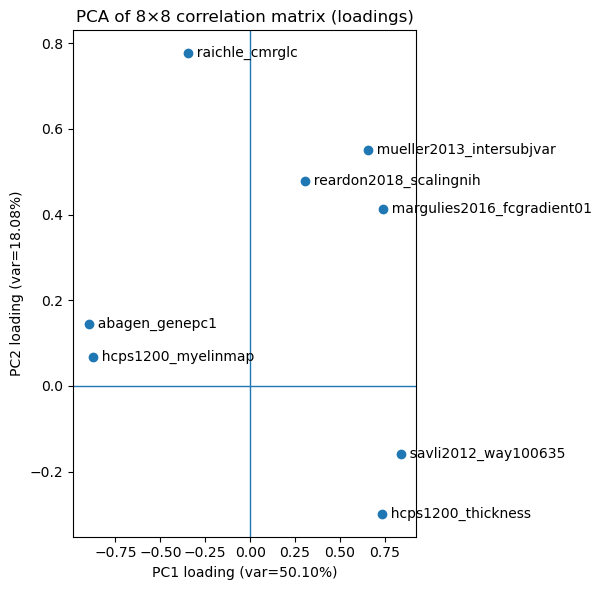

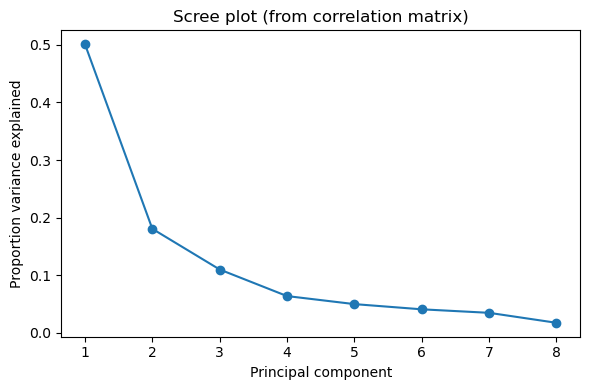

In [17]:
eigvals, eigvecs = np.linalg.eigh(corr_df_spear.values)  # ascending
idx = np.argsort(eigvals)[::-1]       # sort descending
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]
# variance explained
var_exp = eigvals / eigvals.sum()
# Calculate Loadings
loadings = eigvecs * np.sqrt(eigvals)
# Coordinates for PC1/PC2 plot
x = loadings[:, 0]
y = loadings[:, 1]
# Plot: loadings scatter with labels
plt.figure(figsize=(6, 6))
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.scatter(x, y)
for i, name in enumerate(names):
    plt.text(x[i], y[i], "  " + name, va="center")
plt.xlabel(f"PC1 loading (var={var_exp[0]:.2%})")
plt.ylabel(f"PC2 loading (var={var_exp[1]:.2%})")
plt.title("PCA of 8×8 correlation matrix (loadings)")
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 4))
plt.plot(np.arange(1, 9), var_exp, marker="o")
plt.xticks(np.arange(1, 9))
plt.xlabel("Principal component")
plt.ylabel("Proportion variance explained")
plt.title("Scree plot (from correlation matrix)")
plt.tight_layout()
plt.show()

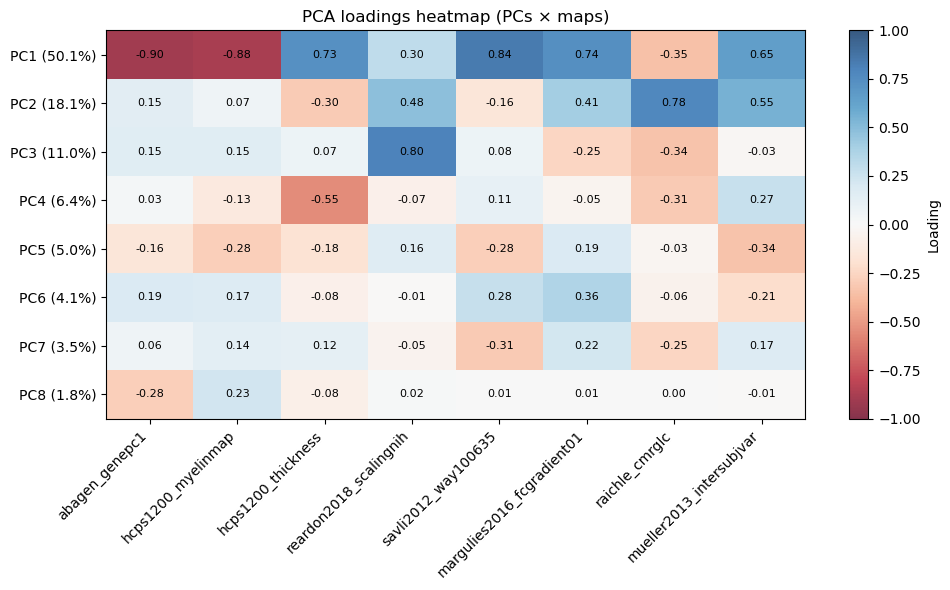

In [18]:
L = loadings.T  # (8 PCs, 8 maps)
plt.figure(figsize=(10, 6))
im = plt.imshow(L, aspect="auto", vmin=-1, vmax=1, cmap='RdBu', alpha=0.8)
# axis labels
plt.xticks(np.arange(len(names)), names, rotation=45, ha="right")
plt.yticks(np.arange(len(L)), [f"PC{i+1} ({var_exp[i]:.1%})" for i in range(len(L))])
plt.title("PCA loadings heatmap (PCs × maps)")
# annotate each cell value
for i in range(len(L)):
    for j in range(len(names)):
        plt.text(j, i, f"{L[i, j]:.2f}", ha="center", va="center", fontsize=8)
plt.colorbar(im, label="Loading")
plt.tight_layout()
plt.show()

## Hierarchical Clustering (Correlation-Derived Distances)

**Goal:** Cluster brain maps based on similarity of their correlation structure to detect whether maps naturally separate into distinct groups.

### Inputs
- `corr_df_spear`: Spearman correlation matrix \(R\).

### Steps implemented in code

1. **Convert correlation matrix to distance matrix**
   - Correlations are converted into distances using:
     $$
     D = 1 - R
     $$
   - High correlation $\Rightarrow$ small distance.
   - Diagonal is set to 0 to enforce self-distance = 0.

   **Code behavior:**
   - `D = 1 - corr_df_spear.values`
   - `np.fill_diagonal(D, 0)`

2. **Convert to condensed distance vector**
   - SciPy’s `linkage` expects a condensed distance vector (upper triangle of $D$).
   - `squareform(D, checks=False)` converts the square matrix to condensed format.
   - `checks=False` skips additional validation and is safe when `D` is known symmetric with zeros on the diagonal.

   **Code behavior:**
   - `D_condensed = squareform(D, checks=False)`

3. **Compute linkage matrix**
   - Agglomerative clustering is performed with `average` linkage:
     $$
     d(A,B) = \frac{1}{|A||B|}\sum_{i\in A}\sum_{j\in B} D_{ij}
     $$
   - The algorithm repeatedly merges the two closest clusters until all items are merged into a dendrogram.

   **Code behavior:**
   - `Z = linkage(D_condensed, method="average")`

4. **Plot dendrogram**
   - The dendrogram visualizes the hierarchy of merges and the distances at which merges occur.
   - Labels correspond to the brain map names (`corr_df.index.tolist()`).

   **Code behavior:**
   - `dendrogram(Z, labels=corr_df.index.tolist(), leaf_rotation=45)`

5. **Extract flat clusters**
   - The dendrogram is cut into `n_clusters = 2` clusters using:
     - `criterion="maxclust"`: produce at most `t` clusters.
   - This yields a cluster assignment per map.

   **Code behavior:**
   - `h_labels = fcluster(Z, t=n_clusters, criterion="maxclust")`
   - Cluster labels stored in a DataFrame:
     - `h_cluster_df = pd.DataFrame({"map": corr_df.index, "cluster": h_labels}).set_index("map")`

### Outputs
- `Z`: linkage matrix encoding hierarchical merge structure
- Dendrogram plot
- `h_labels`: cluster assignment for each map
- `h_cluster_df`: map-to-cluster table

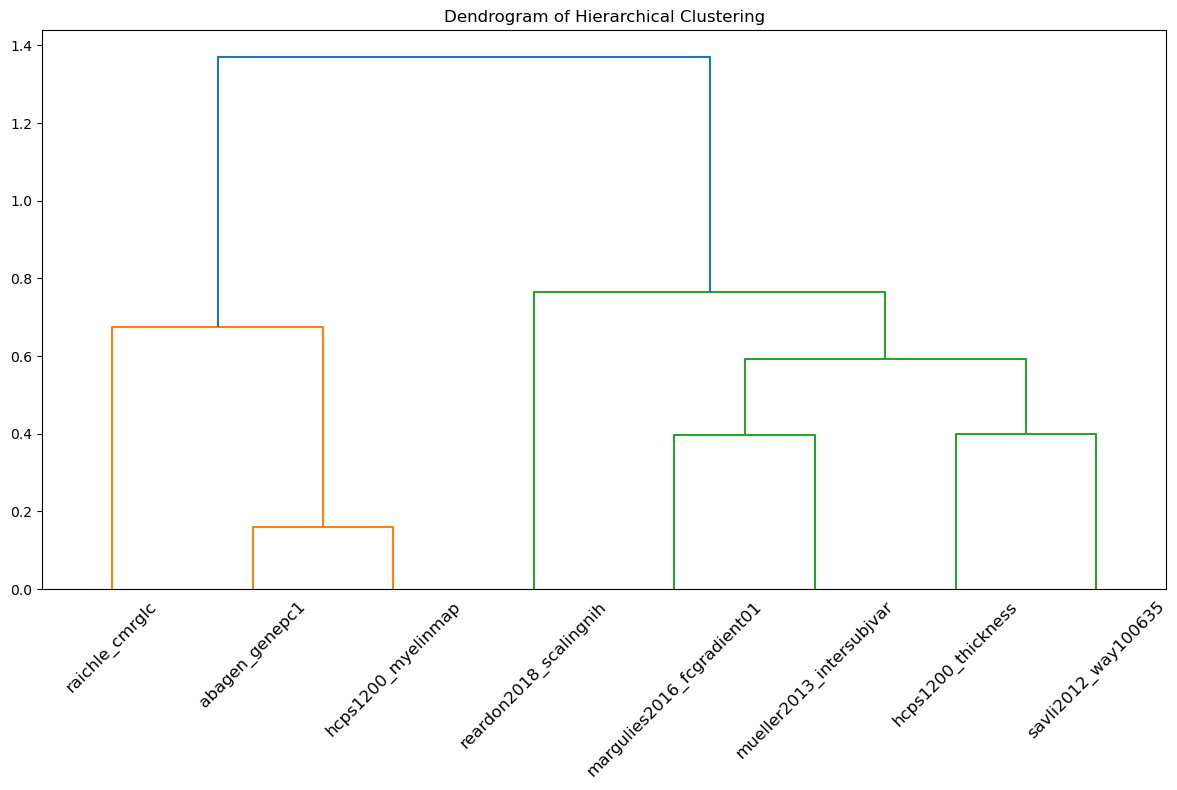

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# distance matrix from correlation
D = 1 - corr_df_spear.values
np.fill_diagonal(D, 0)

# condensed distance for linkage
D_condensed = squareform(D, checks=False)

Z = linkage(D_condensed, method="average")  # also try "complete", "ward" (ward expects Euclidean)
plt.figure(figsize=(12,8))
plt.title("Dendrogram of Hierarchical Clustering")
dendrogram(Z, labels=corr_df.index.tolist(), leaf_rotation=45)
plt.tight_layout()
plt.show()

In [20]:
n_clusters = 2
h_labels = fcluster(Z, t=n_clusters, criterion="maxclust")

h_cluster_df = pd.DataFrame({"map": corr_df.index, "cluster": h_labels}).set_index("map")
h_cluster_df.sort_values("cluster")

,cluster
map,
abagen_genepc1,1
hcps1200_myelinmap,1
raichle_cmrglc,1
hcps1200_thickness,2
reardon2018_scalingnih,2
savli2012_way100635,2
margulies2016_fcgradient01,2
mueller2013_intersubjvar,2


## Subgroup Connectivity Analysis (Within vs Between Clusters)

**Goal:** Quantify whether maps are more strongly correlated *within* clusters than *between* clusters, using mean Spearman correlations.

### Inputs
- `corr_df_spear`: Spearman correlation matrix \(R\).
- `h_labels`: cluster assignments for each map (aligned to `corr_df_spear.index`).

### Definitions
Let the two clusters be index sets \(\mathcal{G}_1\) and \(\mathcal{G}_2\).

- **Within-cluster mean correlation** (excluding diagonal):
  $$
  \bar{r}_{\text{within},1} = \text{mean}\{R_{ij} : i\in \mathcal{G}_1, j\in \mathcal{G}_1, i\neq j\}
  $$
  $$
  \bar{r}_{\text{within},2} = \text{mean}\{R_{ij} : i\in \mathcal{G}_2, j\in \mathcal{G}_2, i\neq j\}
  $$

- **Between-cluster mean correlation**:
  $$
  \bar{r}_{\text{between}} = \text{mean}\{R_{ij} : i\in \mathcal{G}_1, j\in \mathcal{G}_2\}
  $$

### Code logic (as implemented conceptually)

1. **Identify indices per cluster**
- Construct index lists (or boolean masks) for the two clusters based on `h_labels`.

2. **Extract within-cluster blocks**
- Extract the submatrices $R_{11}$ and $R_{22}$.
- Remove diagonal entries before averaging so that self-correlations (=1) do not inflate the mean.

3. **Extract between-cluster block**
- Extract cross-block $R_{12}$ and average all entries.

4. **Summarize**
- Report the three mean correlations:
  - within cluster 1
  - within cluster 2
  - between clusters

### Outputs
- `within_mean_1`: mean Spearman correlation within Cluster 1 (off-diagonal)
- `within_mean_2`: mean Spearman correlation within Cluster 2 (off-diagonal)
- `between_mean`: mean Spearman correlation between clusters
- A summary table used in the Results section

In [21]:
def subgroup_connectivity(corr_df, labels, label_index=None):
    """
    corr_df: (n x n) DataFrame
    labels: array-like length n (in same order as corr_df.index unless label_index provided)
    label_index: optional index aligned to corr_df.index
    """
    if label_index is None:
        label_index = corr_df.index

    lab = pd.Series(labels, index=label_index).reindex(corr_df.index)
    C = corr_df.values
    n = C.shape[0]

    within = []
    between = []
    for i in range(n):
        for j in range(i+1, n):
            if lab.iloc[i] == lab.iloc[j]:
                within.append(C[i,j])
            else:
                between.append(C[i,j])

    return {
        "within_mean": float(np.mean(within)) if within else np.nan,
        "between_mean": float(np.mean(between)) if between else np.nan,
        "within_vals": np.array(within),
        "between_vals": np.array(between),
        "labels": lab
    }

# example using hierarchical labels:
res = subgroup_connectivity(corr_df_spear, h_labels)
res["within_mean"], res["between_mean"]

(0.405097609941765, -0.37024367807313985)

In [22]:
res['labels']

abagen_genepc1                1
hcps1200_myelinmap            1
hcps1200_thickness            2
reardon2018_scalingnih        2
savli2012_way100635           2
margulies2016_fcgradient01    2
raichle_cmrglc                1
mueller2013_intersubjvar      2
dtype: int32

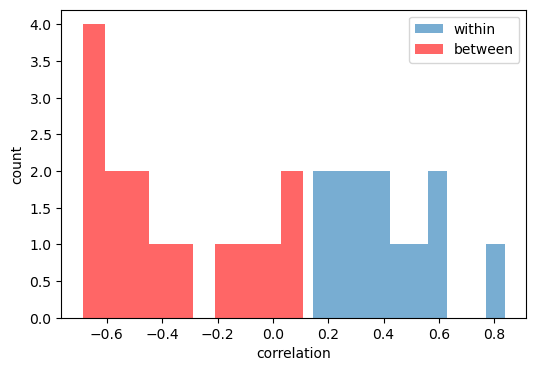

In [23]:
plt.figure(figsize=(6,4))
plt.hist(res["within_vals"], alpha=0.6, label="within")
plt.hist(res["between_vals"], alpha=0.6, label="between", color="r")
plt.legend()
plt.xlabel("correlation")
plt.ylabel("count")
plt.show()

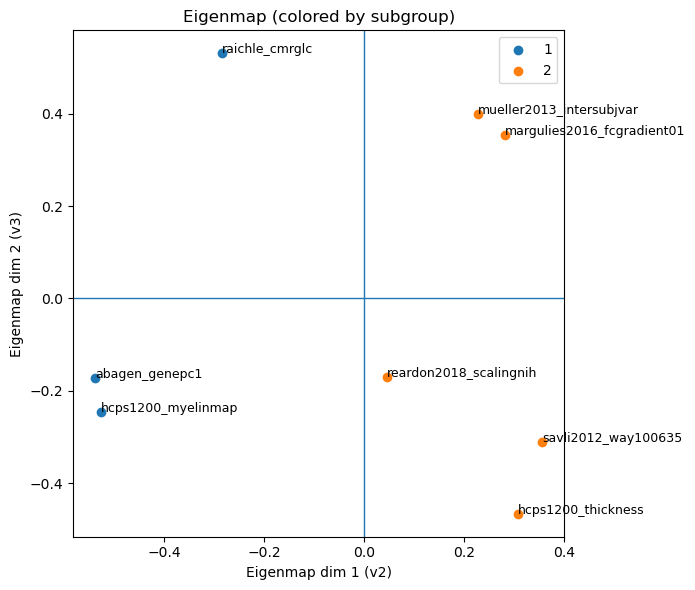

In [24]:
''' This code is not useful '''
# C: (m x m) correlation among m maps
C = corr_df_spear.values

# 1) affinity
W = (C + 1) / 2           # in [0,1]
np.fill_diagonal(W, 0)    # remove self-loops

# 2) normalized Laplacian
deg = W.sum(axis=1)
D_inv_sqrt = np.diag(1.0 / np.sqrt(np.maximum(deg, 1e-12)))
Lsym = np.eye(W.shape[0]) - D_inv_sqrt @ W @ D_inv_sqrt

# 3) eigendecompose
evals, evecs = np.linalg.eigh(Lsym)
order = np.argsort(evals)
evals, evecs = evals[order], evecs[:, order]

# 4) coordinates (skip first trivial eigenvector)
coords2 = evecs[:, 1:3]   # 2D eigenmap of the maps
labels = np.array(res['labels'])

unique = np.unique(labels)
plt.figure(figsize=(7,6))

for lab in unique:
    idx = labels == lab
    plt.scatter(coords2[idx, 0], coords2[idx, 1], label=str(lab))

for i, name in enumerate(names):
    plt.text(coords2[i, 0], coords2[i, 1], name, fontsize=9)

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("Eigenmap dim 1 (v2)")
plt.ylabel("Eigenmap dim 2 (v3)")
plt.title("Eigenmap (colored by subgroup)")
plt.legend()
plt.tight_layout()
plt.show()

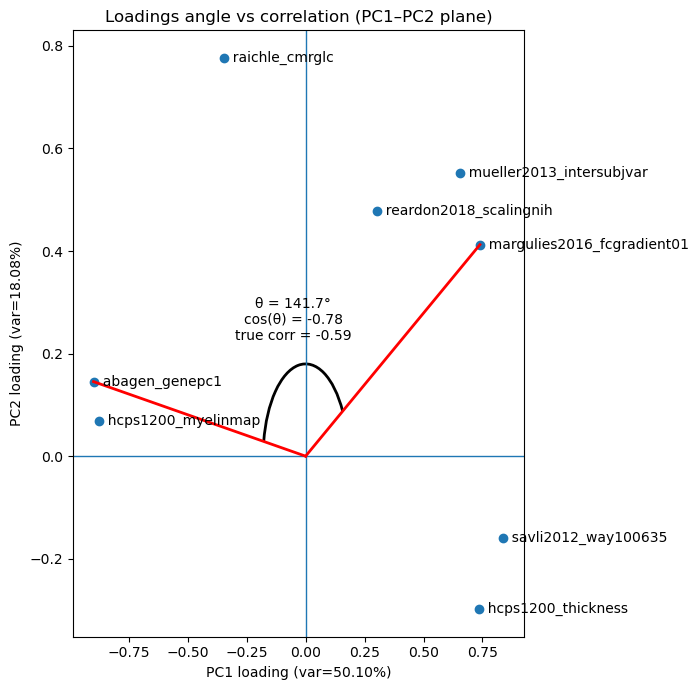

In [25]:
'''
This plot seems buggy

'''
from matplotlib.patches import Arc

# x, y are PC1/PC2 loadings (same order as names)
# names is corr_df_spear.index.to_list()

name_a = "abagen_genepc1"
name_b = "margulies2016_fcgradient01"

i = names.index(name_a)
j = names.index(name_b)

u = np.array([x[i], y[i]])
v = np.array([x[j], y[j]])

# angle between u and v (0..180 degrees)
cos_theta = np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))
cos_theta = np.clip(cos_theta, -1, 1)
theta = np.degrees(np.arccos(cos_theta))

# angles of each ray for drawing
ang_u = np.degrees(np.arctan2(u[1], u[0]))
ang_v = np.degrees(np.arctan2(v[1], v[0]))
ang1, ang2 = sorted([ang_u, ang_v])

# handle wrap-around so we draw the smaller arc
if ang2 - ang1 > 180:
    ang1, ang2 = ang2, ang1 + 360

# actual correlation from your matrix
corr_true = corr_df_spear.loc[name_a, name_b]

# plot
plt.figure(figsize=(7, 7))
plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)

# scatter all points
plt.scatter(x, y)
for k, nm in enumerate(names):
    plt.text(x[k], y[k], "  " + nm, va="center")

# highlight chosen pair
#plt.scatter([u[0], v[0]], [u[1], v[1]], s=80)

# draw rays from origin
plt.plot([0, u[0]], [0, u[1]], linewidth=2, color='r')
plt.plot([0, v[0]], [0, v[1]], linewidth=2, color='r')

# draw angle arc
r = 0.2 * max(np.max(np.abs(x)), np.max(np.abs(y)))  # arc radius scaled to plot
arc = Arc((0, 0), 2*r, 2*r, angle=0, theta1=ang1, theta2=ang2, linewidth=2)
plt.gca().add_patch(arc)

# label the angle near the arc midpoint
mid = np.radians((ang1 + ang2) / 2)
plt.text(r*np.cos(mid)*1.7, r*np.sin(mid)*1.5,
         f"θ = {theta:.1f}°\ncos(θ) = {cos_theta:.2f}\ntrue corr = {corr_true:.2f}",
         ha="center", va="center")

plt.xlabel(f"PC1 loading (var={var_exp[0]:.2%})")
plt.ylabel(f"PC2 loading (var={var_exp[1]:.2%})")
plt.title("Loadings angle vs correlation (PC1–PC2 plane)")
plt.tight_layout()
plt.show()


In [26]:
u, v

(array([-0.89939848,  0.14529974]), array([0.73931076, 0.41248532]))